In [1]:
import os
from Bio.PDB import PDBParser
from Bio.PDB.SASA import ShrakeRupley
from Bio.SeqUtils.ProtParam import ProteinAnalysis

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import BiopythonWarning
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore', BiopythonWarning)

In [2]:
path = './structures_pdb/'
pdb_files = [f for f in os.listdir(path) if f.endswith('pdb')]
#len(pdb_files)

In [3]:
names = set([x.split('_')[0] for x in pdb_files])
cryoem = [i for i in pdb_files if 'cryoem' in i]
native = [i for i in pdb_files if 'native' in i]
qty = [i for i in pdb_files if 'qty' in i]
#len(names), len(cryoem), len(native), len(qty)

In [4]:
def structure_to_sequence(pdb_file):
    
    d3to1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
             'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
             'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
             'ALA': 'A', 'VAL': 'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
    
    p = PDBParser(QUIET = True)
    structure = p.get_structure('structure', pdb_file)    
    
    sequence = []
    for model in structure:
        for chain in model:
            for residue in chain:
                sequence.append(d3to1[residue.resname])
                
    return ''.join(sequence)


def characteristics(pdb_file):
    
    data = []
    
    p = PDBParser(QUIET = True)
    sequence = structure_to_sequence(pdb_file)
    structure = p.get_structure('structure', pdb_file)
    
    #print(f'>{pdb_file.split("/")[-1][:-4]}\n{sequence}')
    
    analysis = ProteinAnalysis(sequence)
    solvent_accessibility = ShrakeRupley()
    
    stability = analysis.instability_index() # Any value above 40 means the protein is unstable
    gravy = analysis.gravy() # Negative GRAVY means the protein is non-polar, positive GRAVY means polar
    flexibility = np.mean(analysis.flexibility())
    #aromaticity = analysis.aromaticity() # Relative frequency of Phe, Trp, and Tyr
    solvent_accessibility.compute(structure, level = 'S') # Protein surface area accessible to a solvent
    sasa = structure.sasa
    
    return [stability, gravy, flexibility, sasa]

In [5]:
d = {k: [] for k in names}

for name in names:
    
    native_file = [i for i in native if i.startswith(name)][0]
    qty_file = [i for i in qty if i.startswith(name)][0]
    
    native_sequence = structure_to_sequence(path + native_file)
    qty_sequence = structure_to_sequence(path + qty_file)
    
    d[name].append(len(native_sequence))
    d[name].append(len(qty_sequence))
        
    try: 
        cryoem_file = [i for i in cryoem if i.startswith(name)][0]
        cryoem_sequence = structure_to_sequence(path + cryoem_file)
        
        #print(f'{name}\n')
        #print(f'{native_sequence}\n')
        #print(f'{qty_sequence}\n')
        #print(f'{cryoem_sequence}\n')
        
        d[name].append(len(cryoem_sequence))
        
    except Exception:
        pass
        d[name].append(None)

In [6]:
data = []

for name in names:
    
    #print(name)
    native_file = [i for i in native if i.startswith(name)][0]
    qty_file = [i for i in qty if i.startswith(name)][0]
    
    native_data = characteristics(path + native_file)
    qty_data = characteristics(path + qty_file)
    
    try: 
        cryoem_file = [i for i in cryoem if i.startswith(name)][0]
        cryoem_data = characteristics(path + cryoem_file)
        
    except Exception:
        cryoem_data = [None, None, None, None]
        
    native_data.extend([name, 'Native']) 
    cryoem_data.extend([name, 'Cryo-EM'])
    qty_data.extend([name, 'QTY'])
    
    data.append(native_data)
    data.append(cryoem_data)
    data.append(qty_data)    

In [7]:
columns = ['Stability', 'GRAVY', 'Flexibility', 'SASA', 'name', 'type']
df = pd.DataFrame(data, columns = columns).fillna(0)
#df.shape

In [8]:
# DeepSoluE predictions

DeepSoluE = [
    
['KCNJ3', 'Native', 0.212, 'insoluble'], 
['KCNJ3', 'QTY', 0.7238, 'soluble'], 
['KCNA1', 'Native', 0.0866, 'insoluble'], 
['KCNA1', 'QTY', 0.8139, 'soluble'], 
['KCNK5', 'Native', 0.089, 'insoluble'], 
['KCNK5', 'QTY', 0.9351, 'soluble'], 
['KCNJ12', 'Native', 0.1077, 'insoluble'], 
['KCNJ12', 'QTY', 0.8808, 'soluble'], 
['KCND1', 'Native', 0.0833, 'insoluble'], 
['KCND1', 'QTY', 0.6976, 'soluble'], 
['KCNN4', 'Native', 0.3357, 'insoluble'], 
['KCNN4', 'QTY', 0.6444, 'soluble'], 
['KCNN4', 'Cryo-EM', 0.3357, 'insoluble'], 
['KCNMA1', 'Native', 0.2342, 'insoluble'], 
['KCNMA1', 'QTY', 0.8307, 'soluble'], 
['KCNMA1', 'Cryo-EM', 0.2342, 'insoluble'], 
['KCNJ8', 'Native', 0.1901, 'insoluble'], 
['KCNJ8', 'QTY', 0.7779, 'soluble'], 
['KCNK9', 'Native', 0.1127, 'insoluble'], 
['KCNK9', 'QTY', 0.884, 'soluble'], 
['KCNH2', 'Native', 0.0557, 'insoluble'], 
['KCNH2', 'QTY', 0.6559, 'soluble'], 
['KCNH2', 'Cryo-EM', 0.0557, 'insoluble'], 
['KCNN3', 'Native', 0.2568, 'insoluble'], 
['KCNN3', 'QTY', 0.6928, 'soluble'], 
['KCNA3', 'Native', 0.0415, 'insoluble'], 
['KCNA3', 'QTY', 0.8647, 'soluble'], 
['KCNA3', 'Cryo-EM', 0.0415, 'insoluble'], 
['KCNJ10', 'Native', 0.1154, 'insoluble'], 
['KCNJ10', 'QTY', 0.5815, 'soluble'], 
['KCNA5', 'Native', 0.081, 'insoluble'], 
['KCNA5', 'QTY', 0.7395, 'soluble'], 
['KCNC4', 'Native', 0.1572, 'insoluble'], 
['KCNC4', 'QTY', 0.7719, 'soluble'], 
['KCNK2', 'Native', 0.0337, 'insoluble'], 
['KCNK2', 'QTY', 0.6799, 'soluble'], 
['KCNK2', 'Cryo-EM', 0.0337, 'insoluble'], 
['KCNH5', 'Native', 0.1099, 'insoluble'], 
['KCNH5', 'QTY', 0.7216, 'soluble'], 
['KCNJ11', 'Native', 0.1562, 'insoluble'], 
['KCNJ11', 'QTY', 0.656, 'soluble'], 
['KCNJ11', 'Cryo-EM', 0.1562, 'insoluble']
    
]

In [9]:
df_temp = pd.DataFrame(DeepSoluE, columns = ['name', 'type', 'Solubility', 'class'])
df = df.merge(df_temp, on = ['name', 'type']).sort_values(by = ['name', 'type'])
df.to_csv('./KCN_protein_characteristics.csv', index = None)

In [10]:
df

,Stability,GRAVY,Flexibility,SASA,name,type,Solubility,class
26,31.864784,0.528058,0.986058,19910.032063,KCNA1,Native,0.0866,insoluble
27,34.434532,-1.072662,1.005657,20051.391644,KCNA1,QTY,0.8139,soluble
16,52.659944,0.248747,0.988070,22801.756989,KCNA3,Cryo-EM,0.0415,insoluble
15,52.659944,0.248747,0.988070,23322.774674,KCNA3,Native,0.0415,insoluble
17,55.405627,-0.882173,1.002253,23553.026285,KCNA3,QTY,0.8647,soluble
9,47.944477,0.369608,0.988834,22411.496902,KCNA5,Native,0.0810,insoluble
10,47.432026,-1.082353,1.006578,22719.335660,KCNA5,QTY,0.7395,soluble
40,36.715110,0.605882,0.979007,19333.620962,KCNC4,Native,0.1572,insoluble
41,32.539338,-0.929044,0.998398,18873.839214,KCNC4,QTY,0.7719,soluble
11,40.746508,0.470238,0.981775,18470.032328,KCND1,Native,0.0833,insoluble


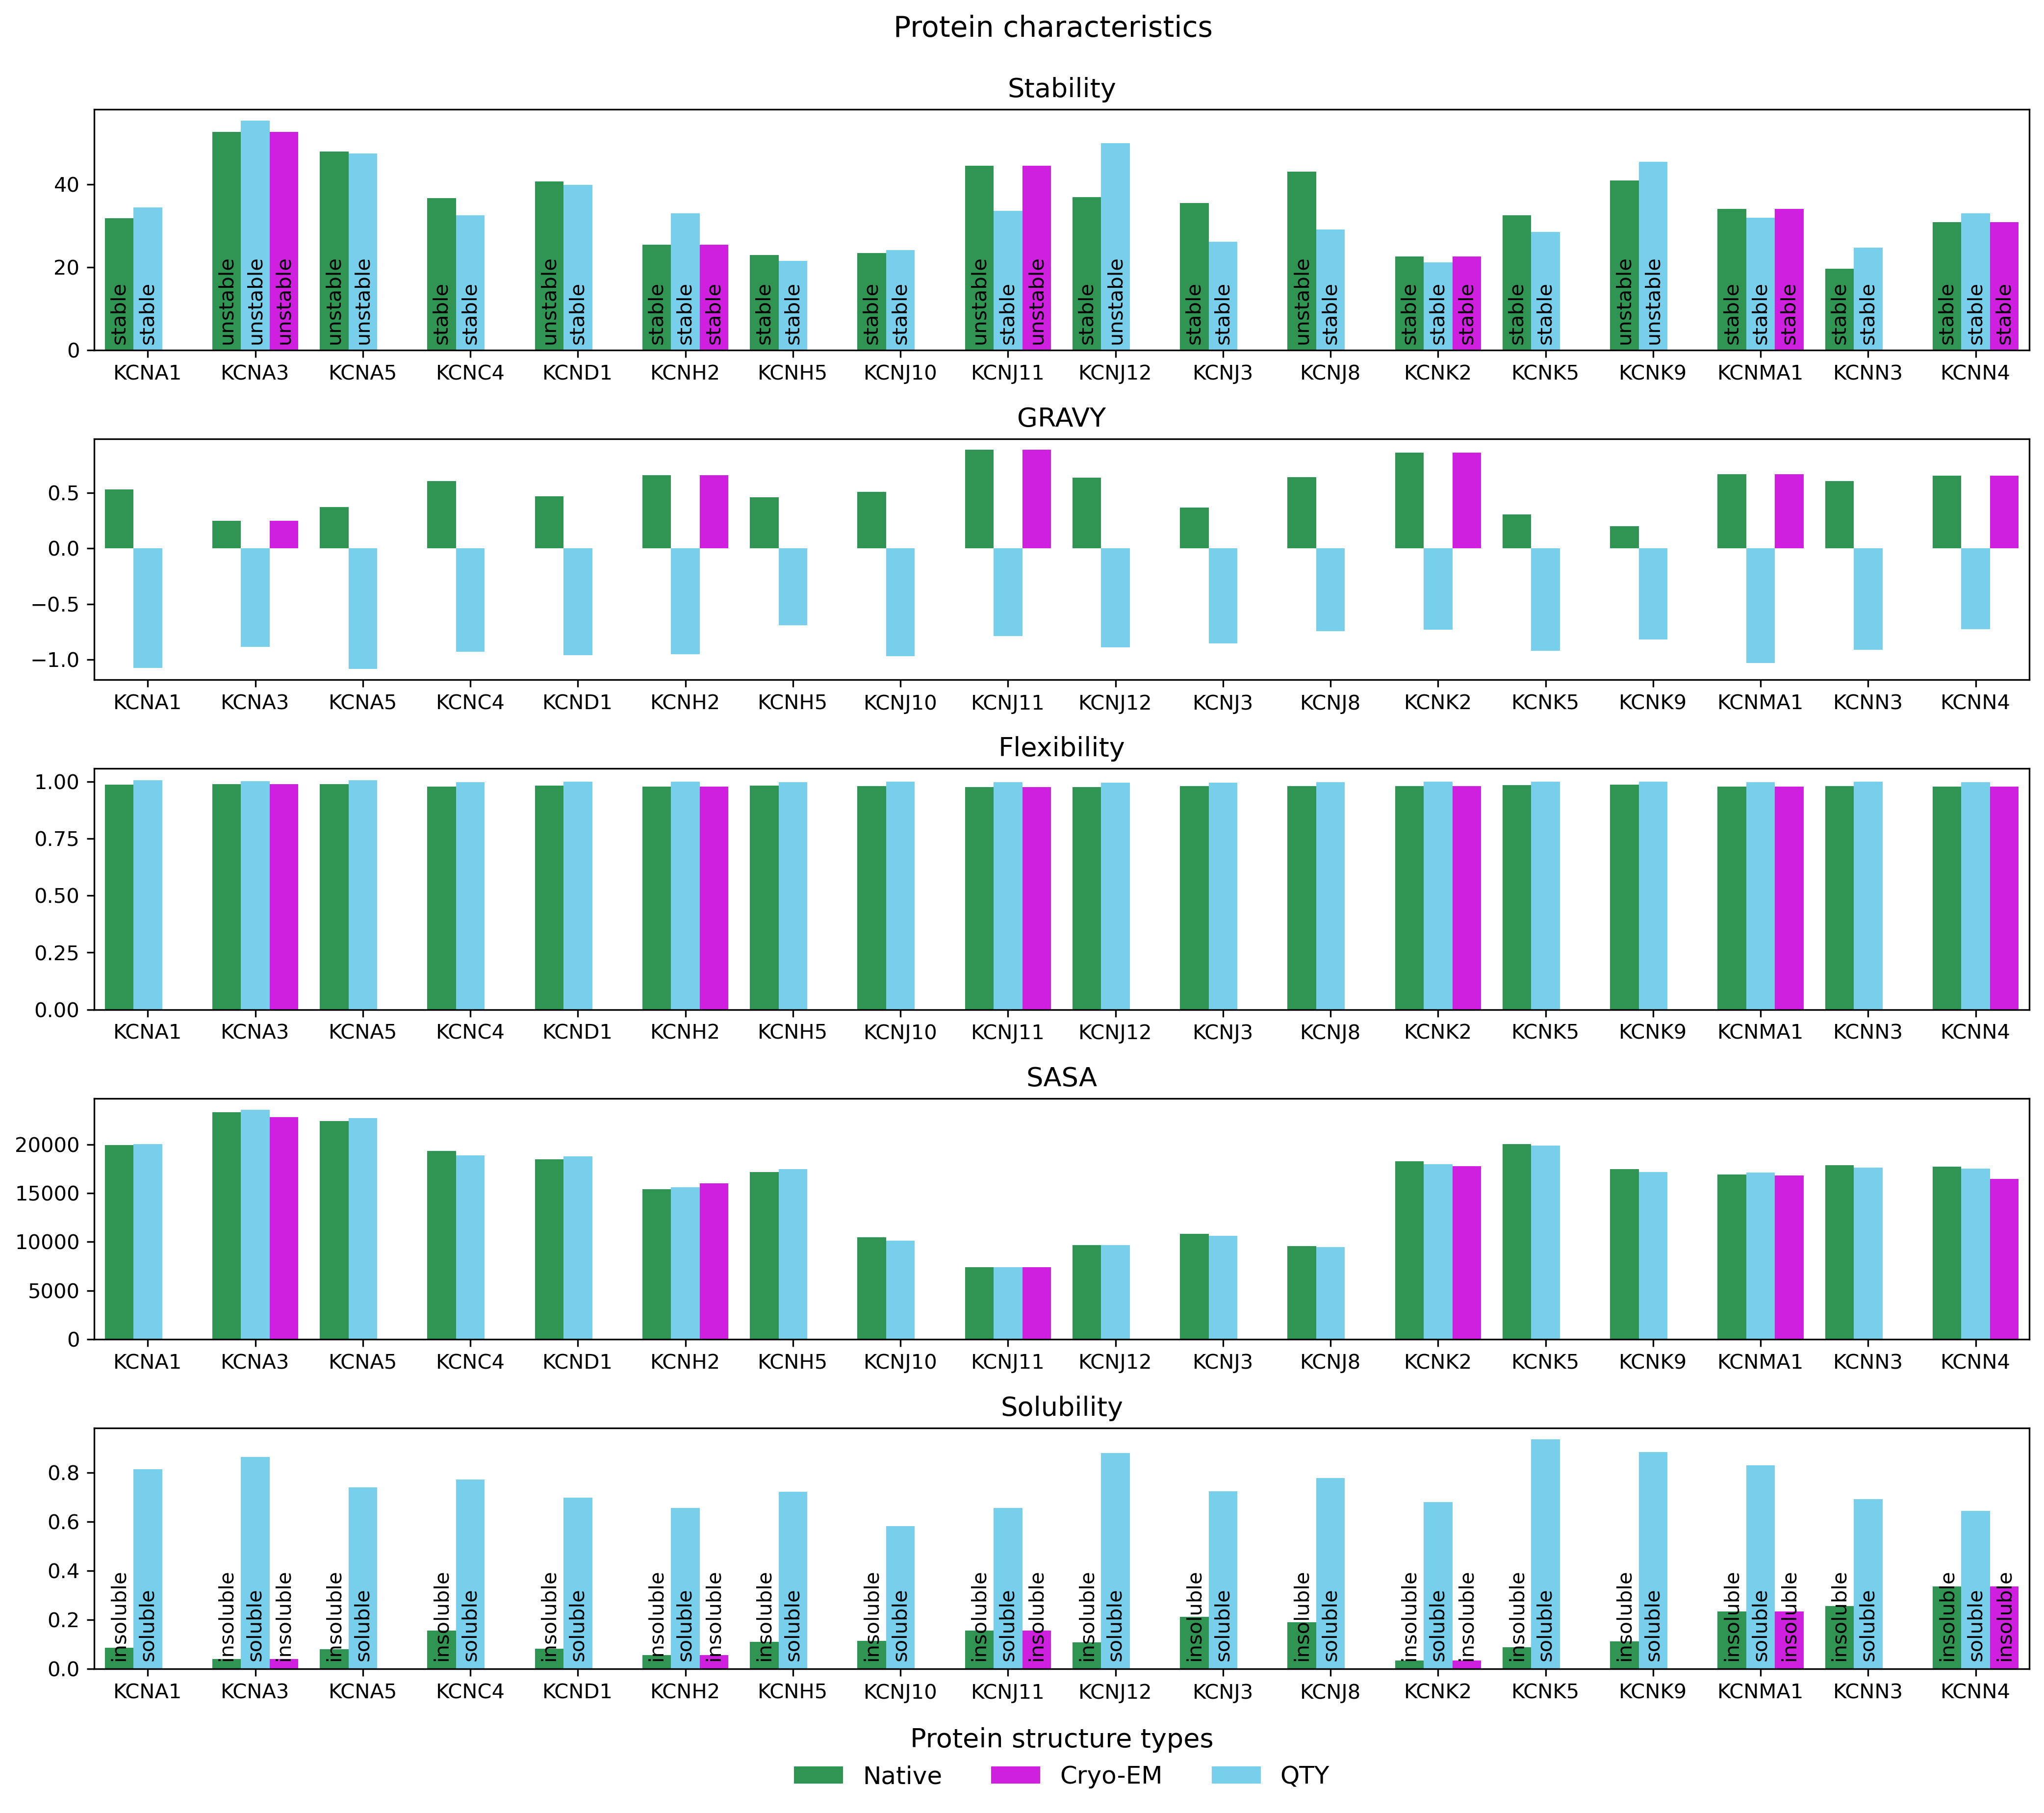

In [11]:
fig, axs = plt.subplots(nrows = 5, ncols = 1, figsize = (14, 12), dpi = 300)
axs = axs.flatten()

colors = ['#1FA64D', '#65D9FF', '#EA00FF'] #  Native, QTY, Cryo-EM
sns.set_palette(sns.color_palette(colors))

parameters = ['Stability', 'GRAVY', 'Flexibility', 'SASA', 'Solubility']

for n, column in enumerate(parameters):
    sns.barplot(data = df, x = 'name', y = column, hue = 'type', ax = axs[n])
    axs[n].set_ylabel('')
    axs[n].set_xlabel('')
    axs[n].get_legend().remove()
    axs[n].set_title(f'{column}', fontsize = 13)
    
for p in axs[0].patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + 2.5
    
    if p.get_height() >= 40:
        value = 'unstable'
    elif p.get_height() < 40:
        value = 'stable'
    else:
        value = None
        
    axs[0].text(_x, _y, value, ha = "center", rotation = 90)

for p in axs[4].patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + 0.05
    
    if p.get_height() >= 0.5:
        value = 'soluble'
    elif p.get_height() < 0.5:
        value = 'insoluble'
    else:
        value = None
        
    axs[4].text(_x, _y, value, ha = "center", rotation = 90)

handles, labels = plt.gca().get_legend_handles_labels()
legend_order = [0, 2, 1]
legend = axs[n].legend([handles[idx] for idx in legend_order],[labels[idx] for idx in legend_order],  
                       loc = 'upper center', bbox_to_anchor = (0.5, -0.15), frameon = False, 
                       fancybox = False, shadow = False, ncol = 3, fontsize = 12)
legend.set_title('Protein structure types', prop = {'size': 13})
    
#fig.text(0.5, -0.01, 'Proteins', ha='center', fontsize = 12)
#fig.text(-0.01, 0.5, 'Characteristics', va='center', rotation='vertical', fontsize = 12)
fig.text(0.515, 1.01, 'Protein characteristics', ha='center', fontsize = 14)
    
plt.tight_layout(pad = 1.1)
#plt.show()
plt.savefig('./kcn_params_bar.png')

In [12]:
types = ['Native', 'Cryo-EM', 'QTY']
kw = {k: [] for k in parameters}

df = df.fillna(0)

for n, column in enumerate(parameters):
    groups = [df[df['type'] == t][column].values for t in types]
        
    kw_native_qty = stats.kruskal(groups[0], groups[2])
    kw_native_cryoem = stats.kruskal(groups[0], groups[1])
    kw_qty_cryoem = stats.kruskal(groups[2], groups[1])
    kw_native_cryoem_qty = stats.kruskal(groups[0], groups[1], groups[2])
    
    kw[column].extend([kw_native_qty.pvalue, kw_native_cryoem.pvalue, kw_qty_cryoem.pvalue, kw_native_cryoem_qty.pvalue])

In [13]:
pairs = [('Native', 'QTY'), ('Native', 'Cryo-EM'), ('Cryo-EM', 'QTY'), ('Native', 'Cryo-EM', 'QTY')]
df_kw = pd.DataFrame(kw.values(), columns = pairs)
df_kw['parameters'] = kw.keys()

In [14]:
df_kw

,"(Native, QTY)","(Native, Cryo-EM)","(Cryo-EM, QTY)","(Native, Cryo-EM, QTY)",parameters
0,7.517095e-01,0.946778,0.893930,9.517158e-01,Stability
1,2.968229e-07,0.095148,0.000318,1.784875e-07,GRAVY
2,2.968229e-07,0.285493,0.000318,2.344111e-07,Flexibility
3,9.747603e-01,0.593803,0.593803,8.472633e-01,SASA
4,2.968229e-07,0.738554,0.000318,2.780225e-07,Solubility


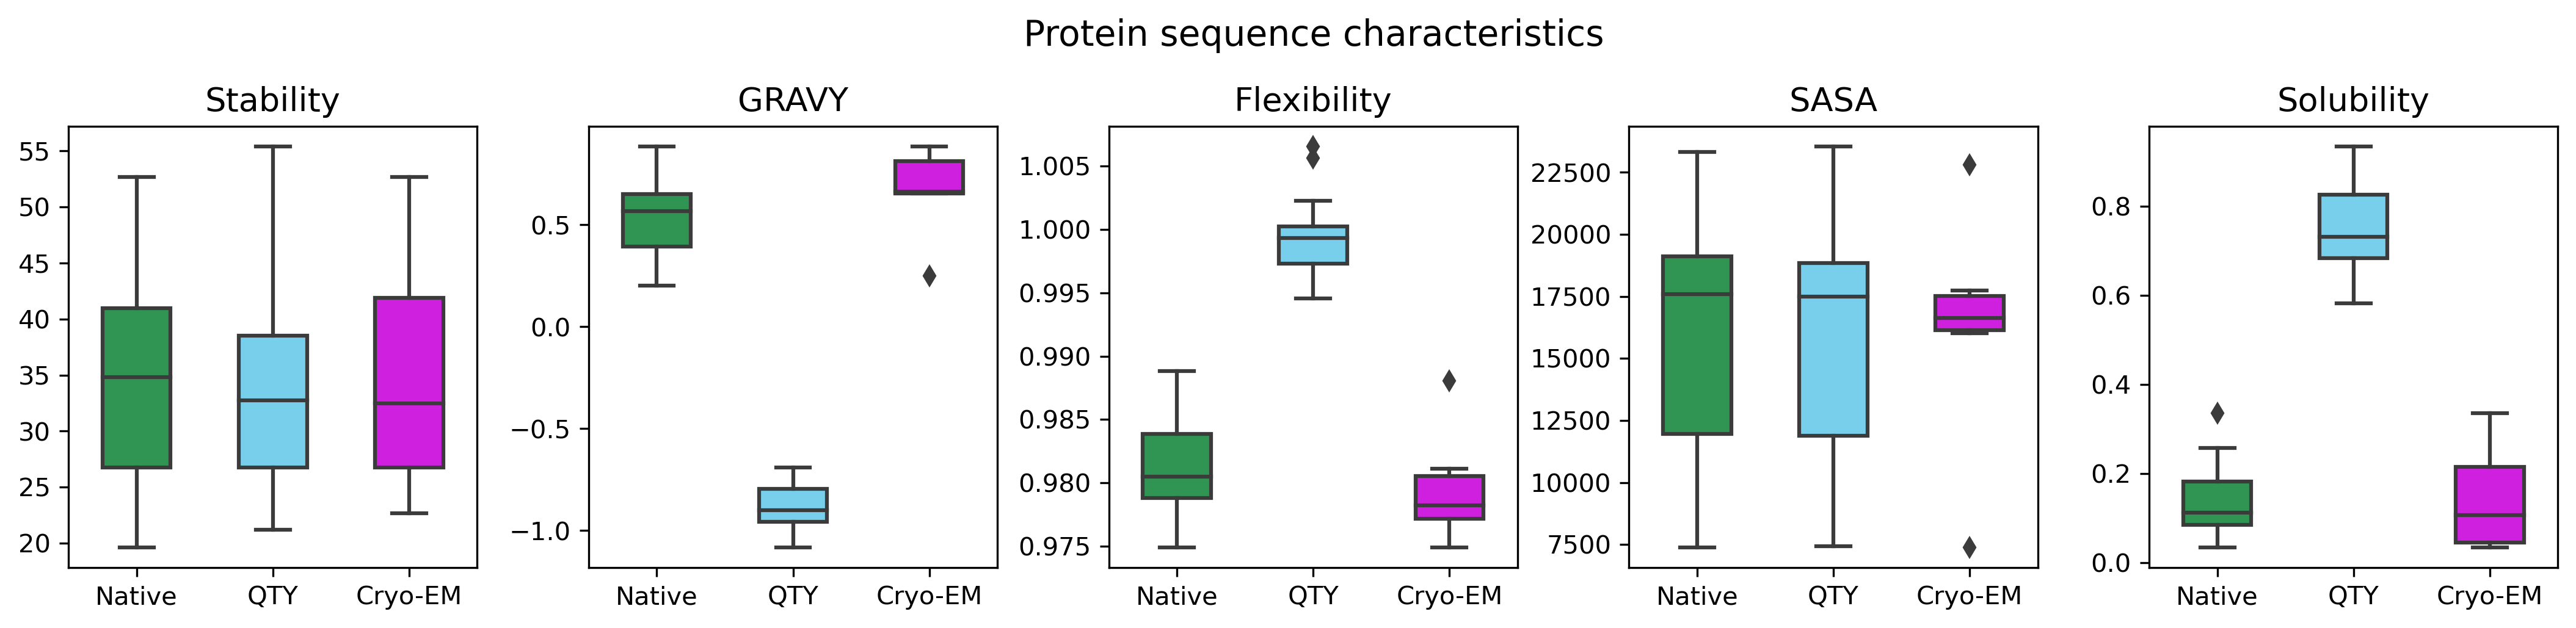

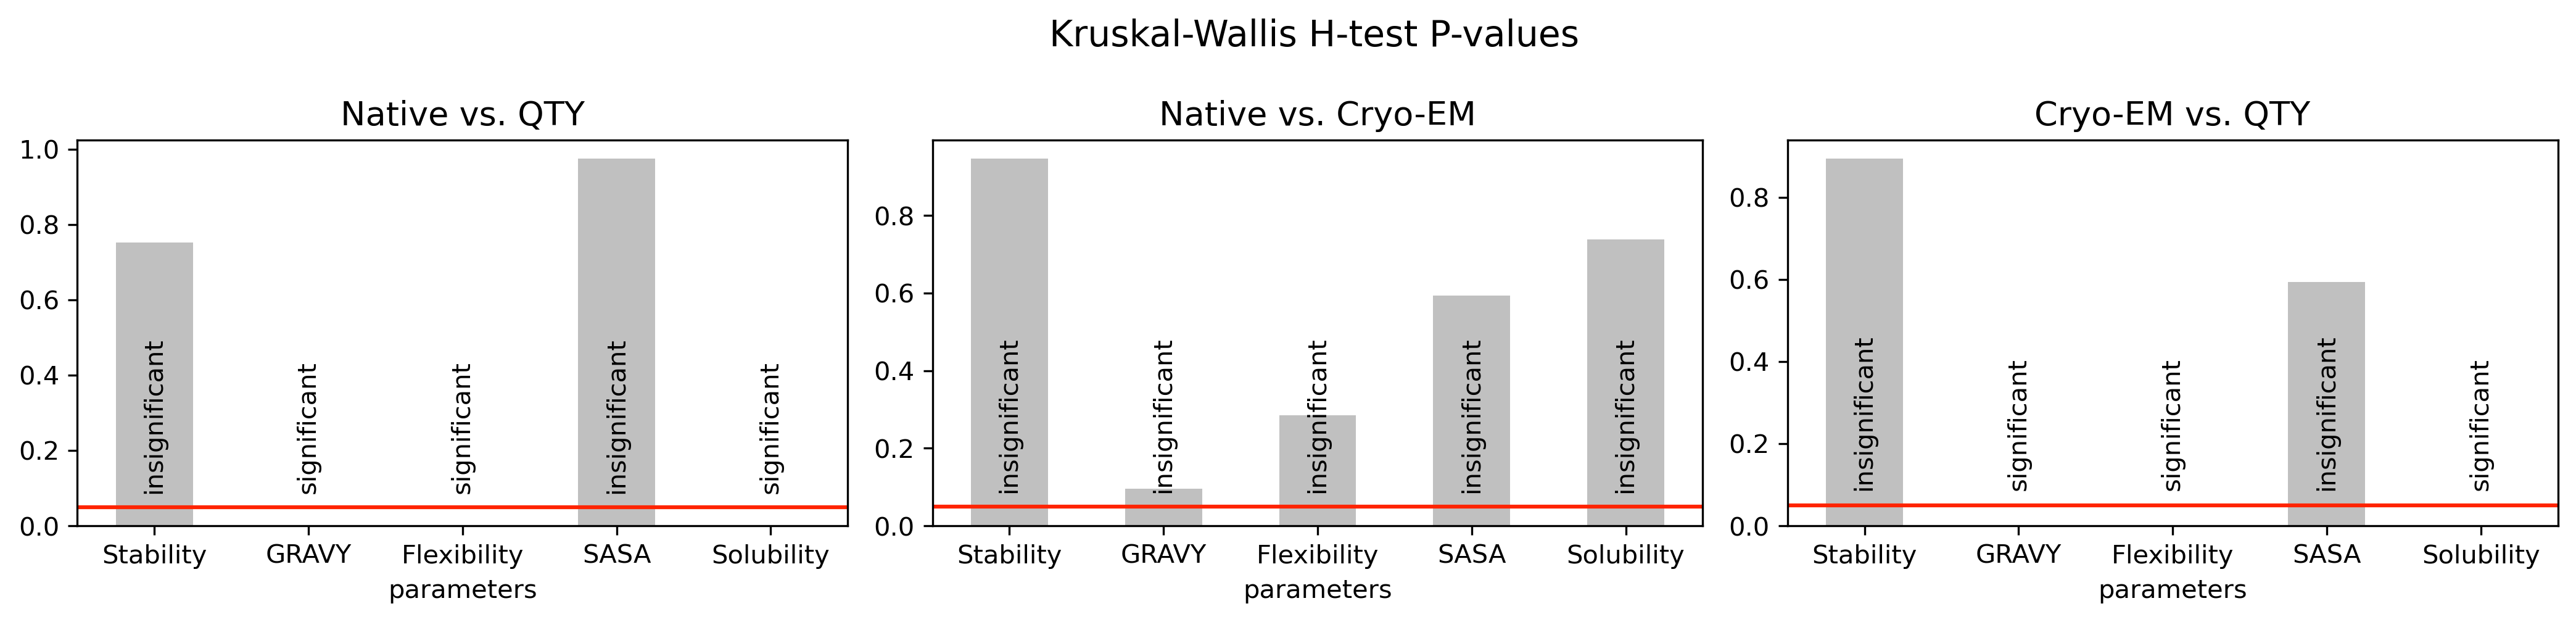

In [15]:
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (14, 3), dpi = 300)
axs = axs.flatten()

colors = ['#1FA64D', '#65D9FF', '#EA00FF'] #  Native, QTY, Cryo-EM
sns.set_palette(sns.color_palette(colors))

parameters = ['Stability', 'GRAVY', 'Flexibility', 'SASA', 'Solubility']
types = ['Native', 'Cryo-EM', 'QTY']
kw = {k: [] for k in parameters}

for n, column in enumerate(parameters):
    sns.boxplot(data = df, y = column, x = 'type', width = 0.5,ax = axs[n])
    axs[n].set_ylabel('')
    axs[n].set_xlabel('')
    axs[n].set_title(f'{column}', fontsize = 13)
    
    
    groups = [df[df['type'] == t][column].values for t in types]
        
    kw_native_qty = stats.kruskal(groups[0], groups[2])
    kw_native_cryoem = stats.kruskal(groups[0], groups[1])
    kw_qty_cryoem = stats.kruskal(groups[2], groups[1])
    kw_native_cryoem_qty = stats.kruskal(groups[0], groups[1], groups[2])
    
    kw[column].extend([kw_native_qty.pvalue, kw_native_cryoem.pvalue, kw_qty_cryoem.pvalue, kw_native_cryoem_qty.pvalue])
    
    
#fig.text(0.5, -0.01, 'Proteins', ha='center', fontsize = 12)
#fig.text(-0.01, 0.5, 'Characteristics', va='center', rotation='vertical', fontsize = 12)
fig.text(0.51, 1.05, 'Protein sequence characteristics', ha='center', fontsize = 14)
    
plt.tight_layout(pad = 0.5)
#plt.show()
plt.savefig('./kcn_params_box.png')


fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (14, 3), dpi = 300)
axs = axs.flatten()

pairs = [('Native', 'QTY'), ('Native', 'Cryo-EM'), ('Cryo-EM', 'QTY'), ('Native', 'Cryo-EM', 'QTY')]
df_kw = pd.DataFrame(kw.values(), columns = pairs)
df_kw['parameters'] = kw.keys()

for n, pair in enumerate(pairs[:-1]):
    g = sns.barplot(data = df_kw, x = 'parameters', y = pair, width = 0.5, color = '#C0C0C0', ax = axs[n])
    g.axhline(0.05, color = '#FF2400')
    axs[n].set_ylabel('')
    axs[n].set_title(f'{" vs. ".join(pair)}', fontsize = 13)
    

for m in range(3):
    for p in axs[m].patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + 0.1

        if p.get_height() >= 0.05:
            value = 'insignificant'
        elif p.get_height() < 0.05:
            value = 'significant'
        else:
            value = None

        axs[m].text(_x, _y, value, ha = "center", rotation = 90)
    
    
fig.text(0.51, 1.05, 'Kruskal-Wallis H-test P-values', ha='center', fontsize = 14)    
plt.tight_layout(pad = 1.0)
#plt.show()
plt.savefig('./kcn_params_kw.png')